## Demonstration of delay_noise_power_wavefield algorithm

This notebook demonstrates how the noise power as a function of delay is computed.  The main steps are
- compute the power in the wavefield as a function of Doppler shift and delay
- for each delay
    1. compute the mean power over a 10-pixel-wide strip at maximum Doppler shift
    2. select all pixels with power less than a threshold times the mean
    3. recompute the mean power, corrected for selection bias (assuming an exponential distribution)
    4. repeat steps 2 and 3 ten times

In [1]:
from scipy.fft import rfft, fft, fftshift, ifft, fftn, ifftn
from scipy.signal import fftconvolve, kaiser
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np

def freq2time(hf, axis=0):
    return hf.shape[axis] * ifft(hf, axis=axis)

def time2freq(ht, axis=0):
    return fft(ht, axis=axis) / ht.shape[axis]

In [2]:
import pickle
with open ("reproduce_0/filters_full_0.pkl", "rb") as fh:
    hf_time = pickle.load(fh)
    
wavefield = time2freq(freq2time(hf_time,axis=1),axis=0)
power=np.abs(wavefield)**2

nsub = wavefield.shape[0]
nchan = wavefield.shape[1]
print(f"nsub={nsub} nchan={nchan}")

nsub=468 nchan=4096


### Plot the wavefield power

The following computes the variance of the wide field of noise at large delay.  It is not part of the delay_noise_power_wavefield algorithm

start=2560 end=3584 size=479232
rms=0.4785162005239152 log10(rms)=-0.32010335427368336


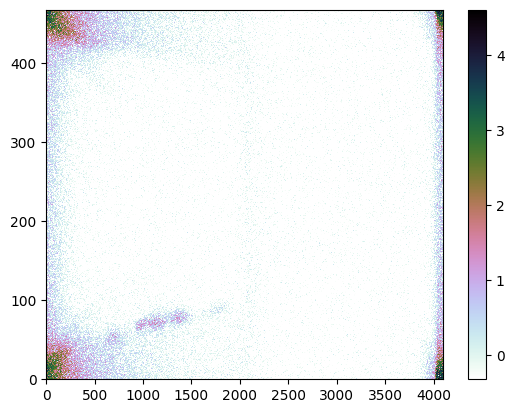

In [3]:
start_chan = nchan*5//8
end_chan = nchan*7//8
noise = wavefield[:,start_chan:end_chan]
print(f'start={start_chan} end={end_chan} size={np.size(noise)}')
variance = np.mean(np.abs(noise)**2)
rms = np.sqrt(variance)
print(f'rms={rms} log10(rms)={np.log10(rms)}')

plotthis = np.log10(power)
plt.imshow(plotthis, aspect="auto", origin="lower", cmap="cubehelix_r", vmin=np.log10(rms), interpolation='none')
plt.colorbar()
plt.show()

#### 1. Compute the mean power over a 10-pixel-wide strip at maximum Doppler shift

In [4]:
total_delay_power = np.mean(power, axis=0)

ndoppler = power.shape[0]
ndelay = power.shape[1]
print(f"delay_noise_power_wavefield ndelay={ndelay} ndoppler={ndoppler}")

# extract a 10-doppler-shift-wide strip at extremes of doppler shift (where signal is expected to be low)
width=10
min=(ndoppler-width)//2
max=(ndoppler+width)//2
edge = power[min:max,:]

sum_edge = np.sum(edge, axis=0)
count_edge = np.maximum(np.count_nonzero(edge, axis=0),1)
edge_delay_power = sum_edge / count_edge

delay_noise_power_wavefield ndelay=4096 ndoppler=468


#### 2. select all pixels with power less than a threshold times the mean
#### 3. recompute the mean power, corrected for selection bias (assuming an exponential distribution)

In [5]:
threshold = 2.0
bias = 1.0 - threshold * np.exp(-threshold) / (1.0 - np.exp(-threshold))

masked_delay_power = edge_delay_power
for i in range(10):
    masked = np.heaviside(threshold * masked_delay_power - power, 1) * power
    sum_masked = np.sum(masked,axis=0)
    count_masked = np.maximum(np.count_nonzero(masked, axis=0),1)
    masked_delay_power = sum_masked / (bias * count_masked)

### Plot the three different estimates of power as a function of delay

Total power, edge power, and masked power are plotted in black, red, and blue, respectively, on a logarithmic scale.

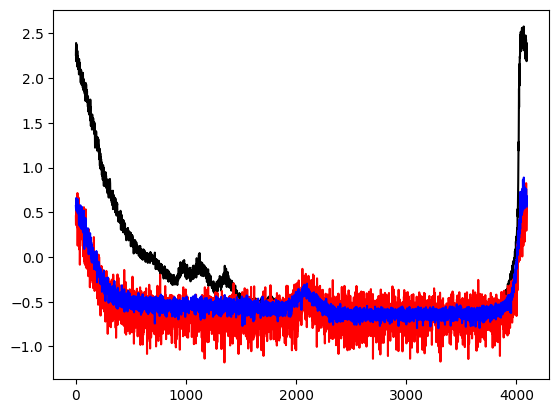

In [6]:
plt.plot(np.log10(total_delay_power),color='black')
plt.plot(np.log10(edge_delay_power),color='red')
plt.plot(np.log10(masked_delay_power),color='blue')
plt.show()

### Plot the number of Doppler shift pixels included in mask as a function of delay

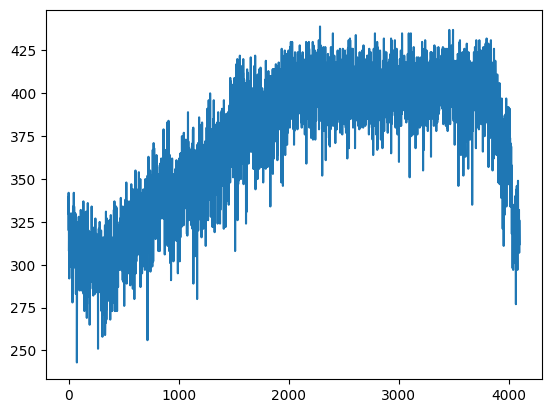

In [7]:
plt.plot(count_masked)    
plt.show()